In [1]:
import h5py
from glob import glob
import sys, scipy
from scipy.stats import chi2

import matplotlib.pyplot as plt
import numpy as np

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


# Get the samples

In [3]:
hlf_features = ['HT', 'MET', 'phiMET', 'MT', 'nJets', 'nBjets',
                'LepPt', 'LepEta', 'LepPhi', 'LepIsoCh',
                'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 'LepIsEle'
               ]

In [4]:
data_folder = '../data/MaxLepDeltaR_des/'

train_list = glob(data_folder +'train/*.h5')
hlf_train = np.zeros((0,14))
label_train = np.zeros((0,))
for fname in train_list:
    f = h5py.File(fname)
    hlf_train = np.concatenate((hlf_train, np.array(f['HLF'])))
    label_train = np.concatenate((label_train, np.array(f['Labels'])[:,1] + 2*np.array(f['Labels'])[:,2]))

    
cut = label_train==0
x_train = hlf_train[cut]
l_train = label_train[cut]
print 'Train data shape: ', x_train.shape    

Train data shape:  (75000, 14)


Pre-processing

In [5]:
PP_means = 0 #np.mean(x_train, axis=0)
PP_std = 1 #np.std(x_train, axis=0)

x_train = (x_train-PP_means)/PP_std

In [6]:
val_list = glob(data_folder +'val/*.h5')
hlf_val = np.zeros((0,14))
label_val = np.zeros((0,))
for fname in val_list:
    f = h5py.File(fname)
    hlf_val = np.concatenate((hlf_val, np.array(f['HLF'])))
    label_val = np.concatenate((label_val, np.array(f['Labels'])[:,1] + 2*np.array(f['Labels'])[:,2]))

cut = label_val==0
x_val = (hlf_val[cut]-PP_means)/PP_std
l_val = label_val[cut]
print 'Validation data shape: ', x_val.shape
    
x_test = (hlf_val-PP_means)/PP_std
l_test = label_val
print 'Test data shape: ', x_test.shape

Validation data shape:  (17500, 14)
Test data shape:  (52500, 14)


In [7]:
samples_name = ['QCD', 'ttbar', 'W+jets']

# Start the VAE declaration

In [8]:
batch_size = 100
original_dim = x_train.shape[1]
latent_dim = 2
intermediate_dim = 20
epsilon_std = 1.0

In [9]:
x = Input(shape=(original_dim,))
h1 = Dense(intermediate_dim, activation='tanh')(x)
h = Dense(intermediate_dim, activation='tanh')(h1)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [10]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [11]:
decoder_h = Dense(intermediate_dim, activation='tanh')
decoder_h1 = Dense(intermediate_dim, activation='tanh')
decoder_mean = Dense(original_dim)
decoder_log_var = Dense(original_dim)

h1_decoded = decoder_h1(z)
h_decoded = decoder_h(h1_decoded)
x_decoded_mean = decoder_mean(h_decoded)
x_decoded_log_var = decoder_log_var(h_decoded)

Custom loss layer

In [12]:
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean, x_decoded_log_var):
        norm_x = K.tf.divide(x-x_decoded_mean, K.exp(x_decoded_log_var))
        single_L = 2*x_decoded_log_var + 0.5*K.square(norm_x)
        nll_loss = K.sum(single_L, axis=-1)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(nll_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        x_decoded_log_var = inputs[2]
        loss = self.vae_loss(x, x_decoded_mean, x_decoded_log_var)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return [x_decoded_mean, x_decoded_log_var]
    
y = CustomVariationalLayer()([x, x_decoded_mean, x_decoded_log_var])

In [13]:
vae = Model(x, y)
vae.compile(optimizer='adam', loss=None)
print vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 14)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 20)           300         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 20)           420         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            42          dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  


# Training

In [15]:
fit_report = vae.fit(x_train,
        shuffle=True,
        epochs=200,
        batch_size=batch_size,
        validation_data=(x_val, None),
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=2, verbose=1)
            ])

Train on 75000 samples, validate on 17500 samples
Epoch 1/200
75000/75000 [==============================] - 1s 17us/step - loss: 2227288.9224 - val_loss: 48131.2306
Epoch 2/200
75000/75000 [==============================] - 1s 13us/step - loss: 27672.6356 - val_loss: 14641.5236
Epoch 3/200
75000/75000 [==============================] - 1s 12us/step - loss: 10425.2651 - val_loss: 7007.8990
Epoch 4/200
75000/75000 [==============================] - 1s 12us/step - loss: 5400.3844 - val_loss: 4019.6198
Epoch 5/200
75000/75000 [==============================] - 1s 12us/step - loss: 3190.4530 - val_loss: 2392.6407
Epoch 6/200
75000/75000 [==============================] - 1s 12us/step - loss: 1968.6948 - val_loss: 1552.8640
Epoch 7/200
75000/75000 [==============================] - 1s 12us/step - loss: 1284.0198 - val_loss: 1019.0780
Epoch 8/200
75000/75000 [==============================] - 1s 12us/step - loss: 843.6057 - val_loss: 681.5713
Epoch 9/200
75000/75000 [========================

Epoch 70/200
75000/75000 [==============================] - 1s 13us/step - loss: -3.2084 - val_loss: -4.3714
Epoch 71/200
75000/75000 [==============================] - 1s 12us/step - loss: 2.1517 - val_loss: -2.2399
Epoch 72/200
75000/75000 [==============================] - 1s 12us/step - loss: -2.9739 - val_loss: -4.4885
Epoch 73/200
75000/75000 [==============================] - 1s 12us/step - loss: 261.4608 - val_loss: 1.3278
Epoch 74/200
75000/75000 [==============================] - 1s 12us/step - loss: 0.0123 - val_loss: -1.1009
Epoch 75/200
70500/75000 [===========================>..] - ETA: 0s - loss: -1.3167
Epoch 00075: reducing learning rate to 4.6655999904e-05.
75000/75000 [==============================] - 1s 12us/step - loss: -1.3980 - val_loss: -2.1720
Epoch 76/200
75000/75000 [==============================] - 1s 12us/step - loss: -2.2287 - val_loss: -2.8585
Epoch 77/200
70300/75000 [===========================>..] - ETA: 0s - loss: -1.6209
Epoch 00077: reducing learn

In [1]:
for item in ['loss', 'val_loss']:
    plt.semilogy(np.array(fit_report.history[item][2:])+50., label=item)
plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')

NameError: name 'plt' is not defined

In [66]:
vae.save('last_saved_VAE.h5')

In [67]:
if 0:
    from keras.models import load_model
    vae = load_model('last_saved_VAE.h5')
    print 'Loaded'

# Build encoder and decoder

### Encoder

In [17]:
encoder = Model(inputs=x, outputs=[z_mean, z_log_var])

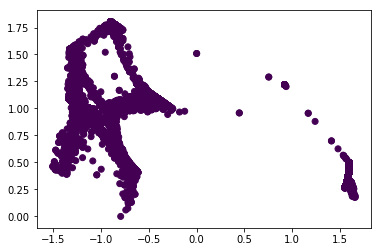

In [18]:
x_train_encoded = np.array(encoder.predict(x_train, batch_size=batch_size))
x_train_encoded.shape
plt.figure()
plt.scatter(x_train_encoded[0, :, 0], x_train_encoded[0, :, 1], c=l_train)
plt.show()

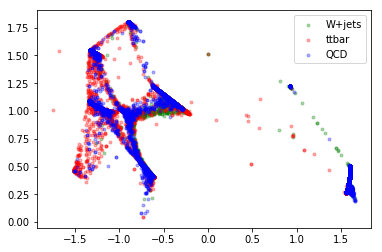

In [69]:
x_test_encoded = np.array(encoder.predict(x_test, batch_size=batch_size))
colors = ['b','r','g']
plt.figure()
for i in reversed(range(3)):
    cut = label_val == i
    plt.scatter(x_test_encoded[0, :, 0][cut], x_test_encoded[0, :, 1][cut], 
                c=colors[i], marker='.',
               label=samples_name[i], alpha=0.3)
plt.legend(loc='best')
plt.show()

## Probabilistic Decoder

In [20]:
decoder_input = Input(shape=(latent_dim,))
_h1_decoded = decoder_h1(decoder_input)
_h_decoded = decoder_h(_h1_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
_x_decoded_log_var = decoder_log_var(_h_decoded)
decoder = Model(decoder_input, [_x_decoded_mean, _x_decoded_log_var])

## Recostruction sum of pdf

In [140]:
def sum_of_gaussians(x, mu_vec, sigma_vec):
    x = np.atleast_2d(x)
    if x.shape[0] <= x.shape[1]:
        x = x.T
    x_norm = (x - mu_vec)/sigma_vec
    single_gaus_val = np.exp(-0.5*np.square(x_norm))/(sigma_vec*np.sqrt(2*np.pi))
    return np.sum(single_gaus_val, axis=1)/mu_vec.shape[0]

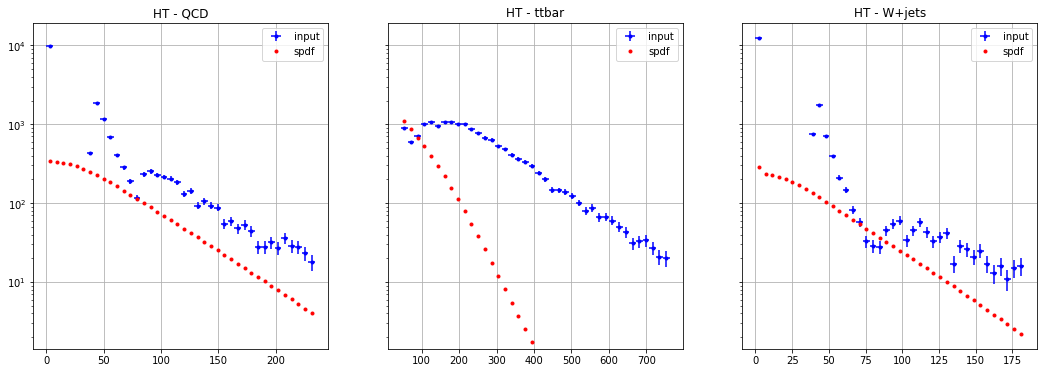

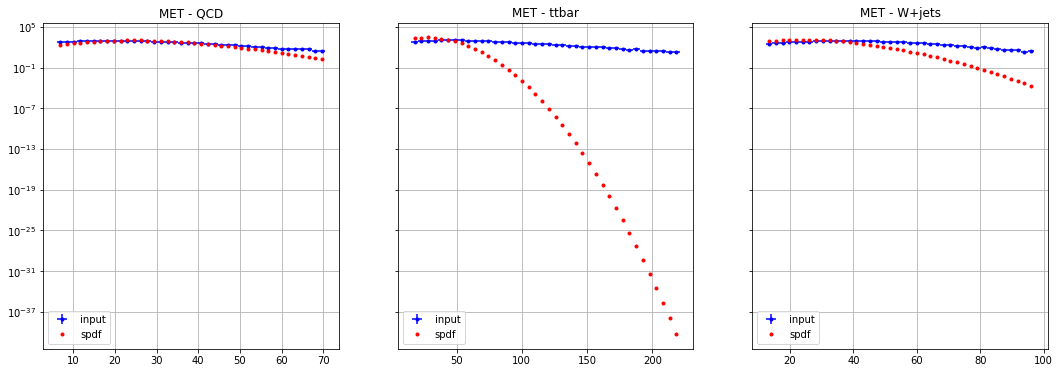

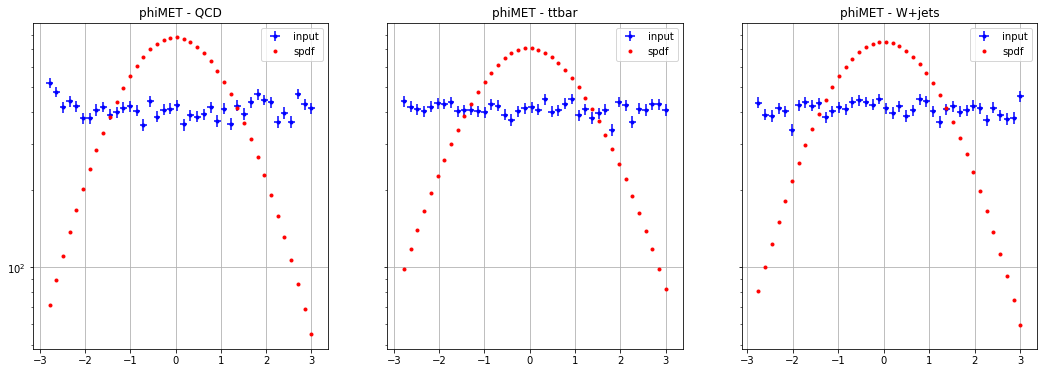

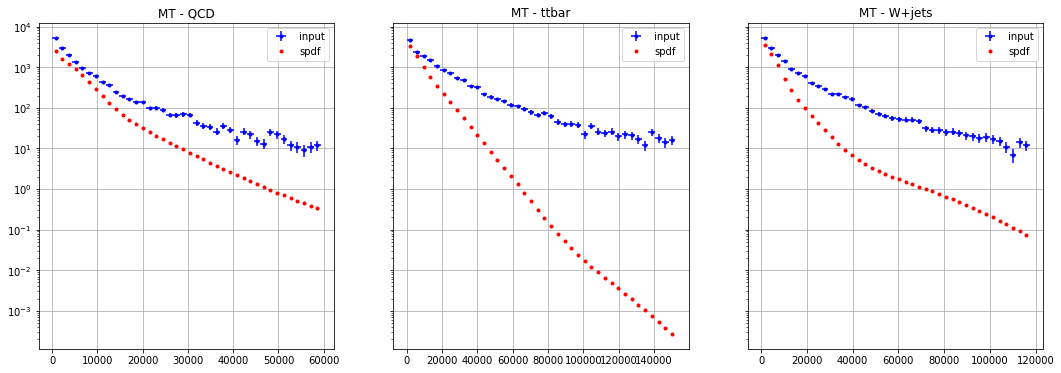

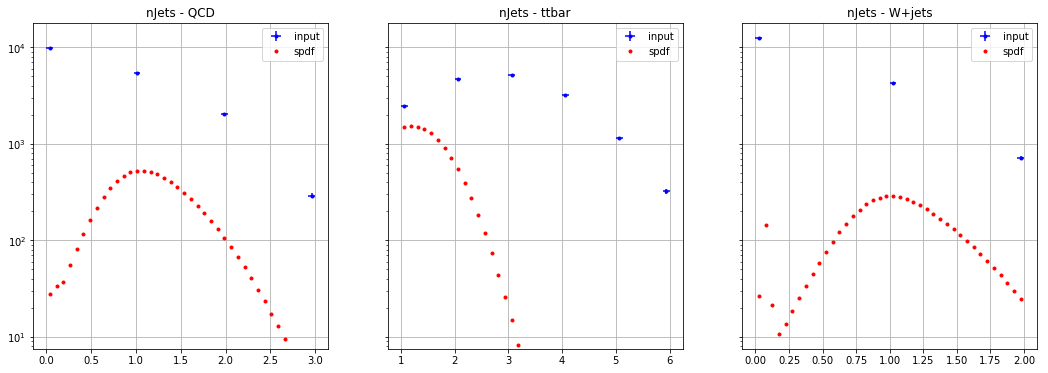

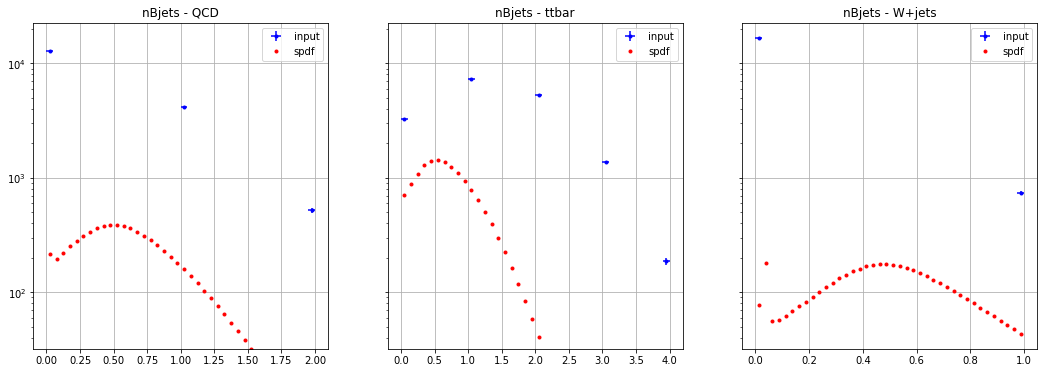

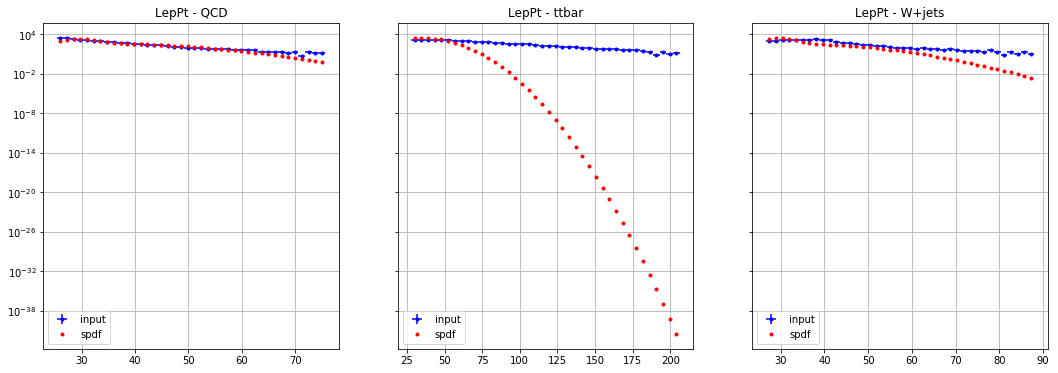

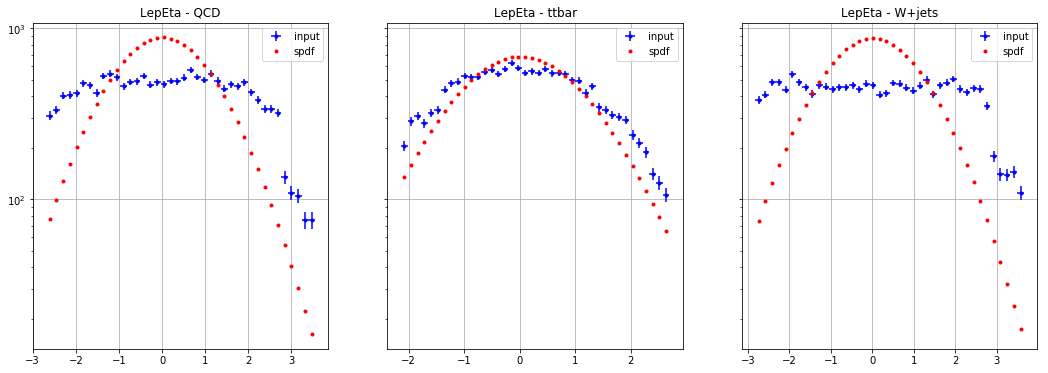

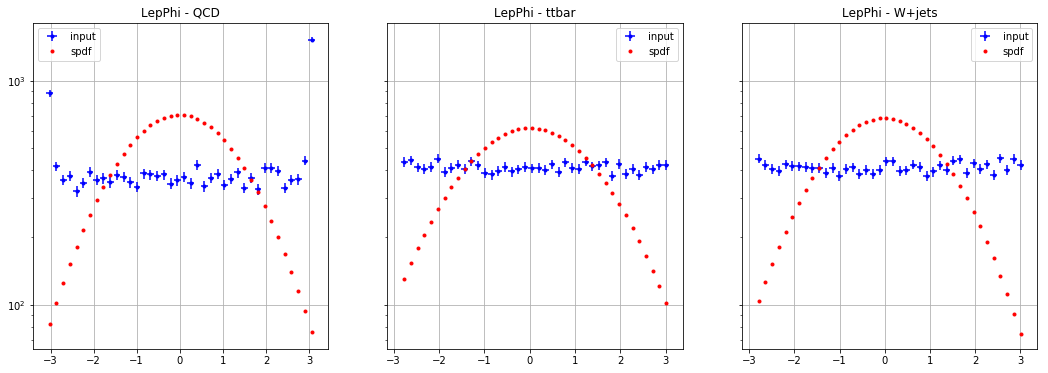

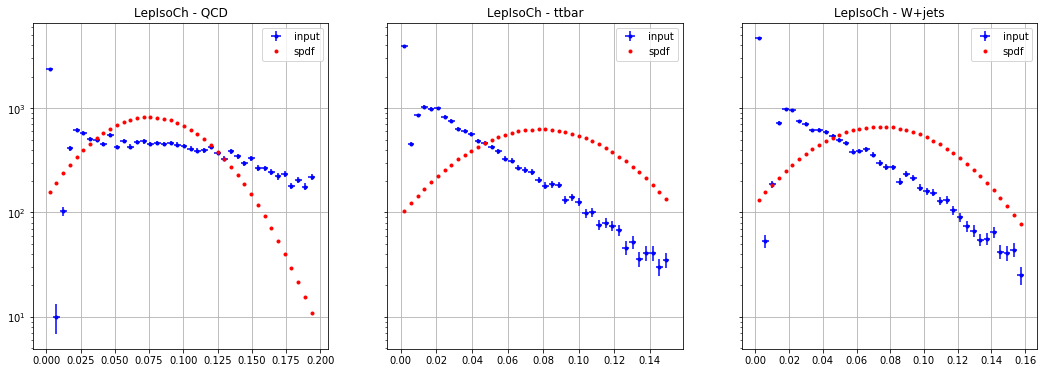

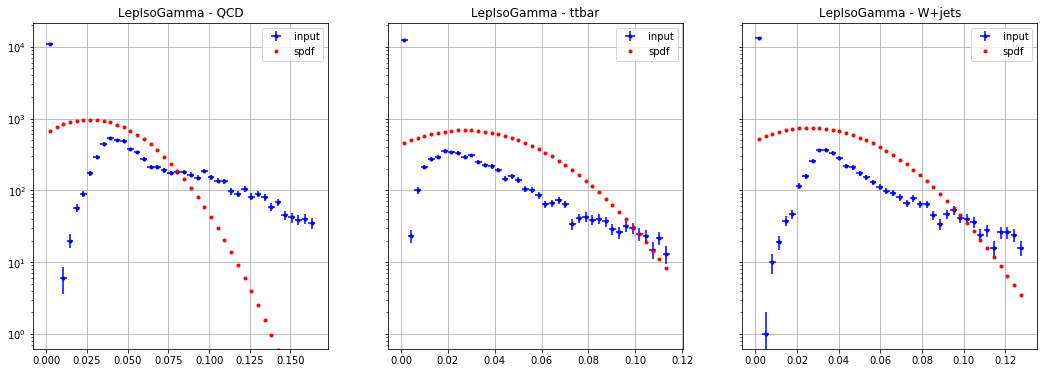

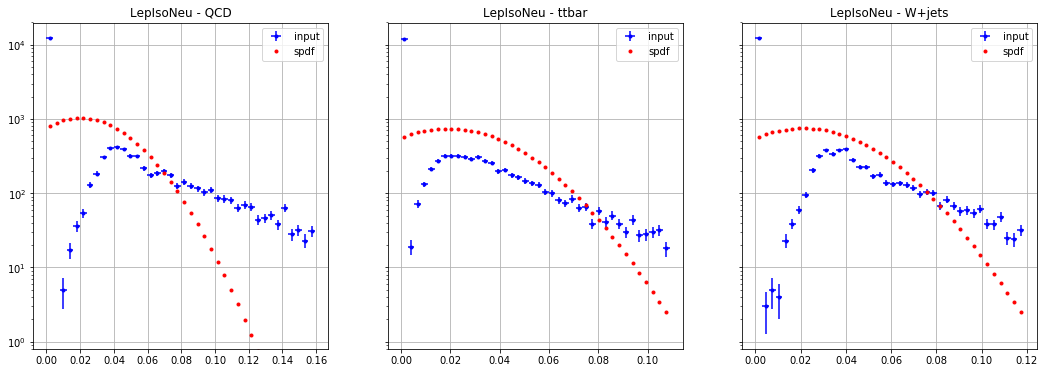

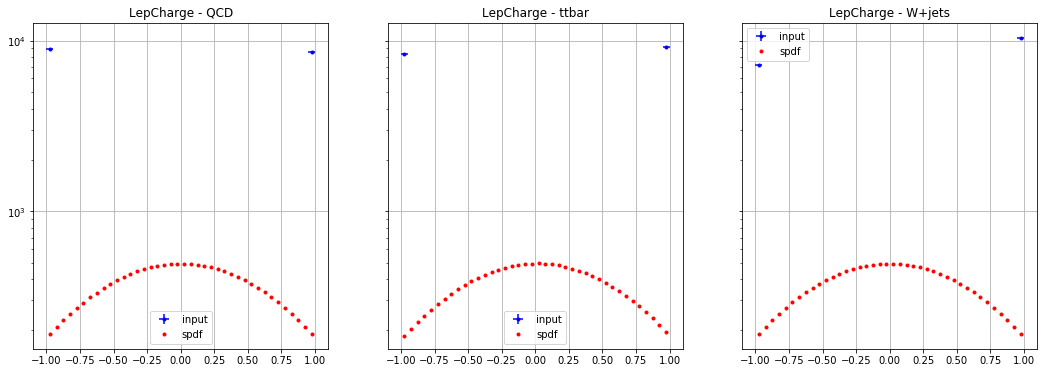

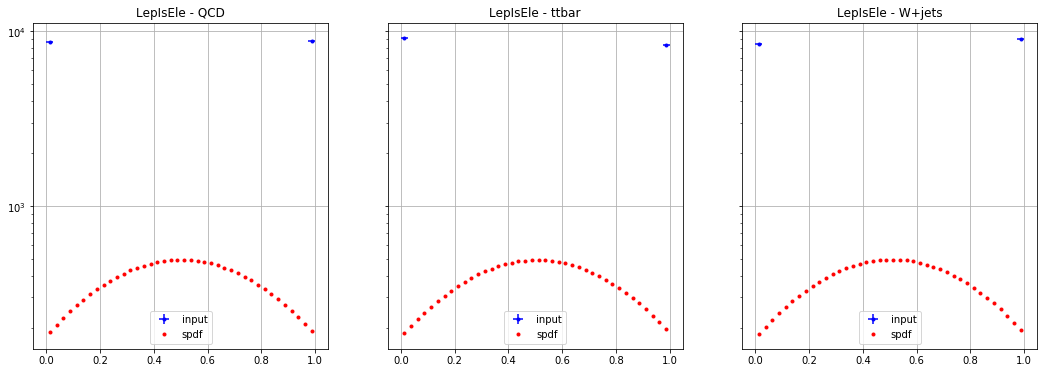

In [156]:
x_autoencoded_pars = vae.predict(x_test)

for i,hlf_name in enumerate(hlf_features):
    f, ax_arr = plt.subplots(1,3, figsize=(18,6), sharey=True)
    plt.yscale('log', nonposy='clip')
    for k, sample in enumerate(samples_name):
        #Plot distribution of the variable
        x_aux = x_test[l_test==k, i]
        histo_range = (np.percentile(x_aux, 5.), np.percentile(x_aux, 99.))
        bin_content, bin_edges = np.histogram(x_aux, bins=40, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        ax_arr[k].errorbar(bincenters, bin_content, xerr=bin_width/2., yerr=np.sqrt(bin_content), fmt='.b', label='input')
        ax_arr[k].grid()
        ax_arr[k].set_title(hlf_name + ' - ' + sample)
        
        mu_vec = x_autoencoded_pars[0][l_test==k, i]
        sigma_vec = np.exp(x_autoencoded_pars[1][l_test==k, i])
        
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_gaussians(bincenters, mu_vec, sigma_vec)
        ax_arr[k].errorbar(bincenters, spdf_bin_content, fmt='.r', label='spdf')
        
        ax_arr[k].legend(loc='best')
        
plt.show()

# Note for next version:
Change the interpretaion of the parameters that the NN is producing such that distribution differen from gaussian are taken into account.
In particular use discrete distributions for discrete variables.

## Recostruction p-value

In [23]:
L_trials = 5
comb_pvalue = []
for i, x_aux in enumerate(x_test):
    if i%10000==0: print i
    x_aux = np.atleast_2d(x_aux)
    pred = encoder.predict(x_aux)
    aux_pval = 0
    for i in range(L_trials):
        z_aux = np.random.normal(loc=pred[0], scale=np.exp(pred[1]))
        pred_x = decoder.predict(z_aux)
        mu = pred_x[0]
        sigma = np.exp(pred_x[1])
        x_norm = (x_aux-mu)/sigma
        pvalue = 1-np.abs(scipy.special.erf(x_norm))/np.sqrt(2)
        aux_pval += 1-chi2.cdf(-2*np.sum(np.log(pvalue)), 2*pvalue.shape[1])
    comb_pvalue.append(aux_pval/float(L_trials))
comb_pvalue = np.array(comb_pvalue)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000


Text(0,0.5,u'Number of events')

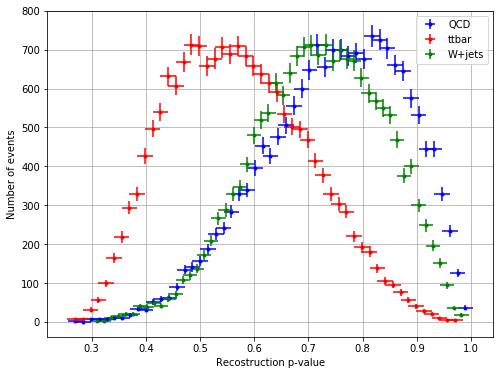

In [154]:
plt.figure(figsize=(8,6))
for i in range(3):
    cut = l_test==i
#     plt.hist(comb_pvalue[cut], facecolor=colors[i], alpha=0.5, label=samples_name[i], bins=40, fill=False, lw=2)
    bin_content, bin_edges = np.histogram(comb_pvalue[cut], bins='auto')
    bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
    plt.errorbar(bincenters, bin_content, xerr=bin_edges[1]-bin_edges[0], yerr=np.sqrt(bin_content), fmt='.'+colors[i], label=samples_name[i])

# plt.yscale('log', nonposy='clip')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Recostruction p-value')
plt.ylabel('Number of events')

In [149]:
q = np.arange(0.01,1,0.1)
np.percentile()

array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91])